In [ ]:
import os
import pickle
import numpy as np
import tensorflow as tf

In [ ]:
from tensorflow.contrib.layers import fully_connected
from sklearn.preprocessing import MultiLabelBinarizer

In [ ]:
from Scripts.CreateTrainingBatches import CreateTrainingBatches

In [ ]:
with open(os.path.join('Data','data_X_y.p'), 'rb') as handle:
    data_X_y = pickle.load(handle)

with open(os.path.join('Data','training_params.p'), 'rb') as handle:
    training_params = pickle.load(handle)

In [ ]:
X_train, X_valid, X_test = [data_X_y['X_train'],data_X_y['X_valid'], data_X_y['X_test']]
y_train, y_valid, y_test = [data_X_y['y_train'],data_X_y['y_valid'], data_X_y['y_test']]

In [ ]:
vocab_size = training_params['vocab_size']
mlb = MultiLabelBinarizer()
X_train = mlb.fit_transform(X_train)
X_valid = mlb.transform(X_valid)

In [ ]:
create_training_batches_object = CreateTrainingBatches(X_train, y_train, X_valid, y_valid)

In [ ]:
def print_metrics(np_prob, np_y):
    neg_accuracy = np.mean((np_prob<0.5)[(np_y==0)])
    pos_accuracy = np.mean((np_prob>0.5)[(np_y==1)])
    accuracy = np.mean((pos_accuracy, neg_accuracy))
    print('Negative accuracy',neg_accuracy)
    print('Positive accuracy',pos_accuracy)
    print('Accuracy', accuracy)
    return accuracy

Given an input $x$, the model should be able to map it to $\hat{y}$
\begin{align}
\hat{y} & = \sigma(w^Tx+b) \\
\end{align}
The paramters of the model are the weights $w$ and the bias $b$

In [ ]:
tf.reset_default_graph()
learning_rate = 0.01

doc_vectors = tf.placeholder(dtype=tf.float32,shape=[None, vocab_size], name='doc_vectors')
logits = fully_connected(doc_vectors, 1, activation_fn=None)
prob = tf.nn.sigmoid(logits, name='prob')

The loss is an estimate the difference between the true label $y$ and the predicted label $\hat{y}$
\begin{align}
\ L(\hat{y},y) & = - [y log(\hat{y}) + (1 - y) log(1 - \hat{y})] \\
\end{align}

In [ ]:
y = tf.placeholder(tf.float32, [None, 1], name='y')
losses = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits, name='x_entropy')
loss = tf.reduce_mean(losses, name='loss')

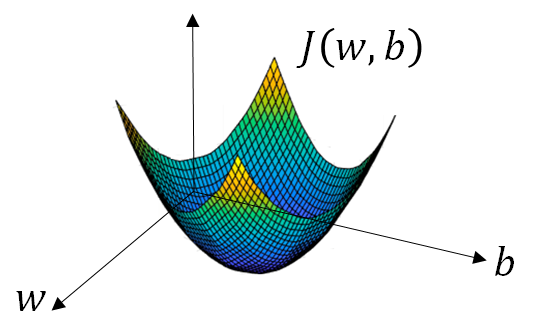 

Update the Parameter to minimze the loss
Here $\alpha$ is the learning rate and $\frac{\partial L}{\partial w}$ is the partial derivative of Loss $L$ with respect to weight $w$
\begin{align}
\ w = w - \alpha \frac{\partial L}{\partial w}\\
\ b = b - \alpha \frac{\partial L}{\partial b}\\
\end{align}

In [ ]:
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss, name='train_op')

In [ ]:
file_writer = tf.summary.FileWriter('tf_logs/logistic_regression', tf.get_default_graph())

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
sess = tf.InteractiveSession()
init.run()

In [ ]:
highest_validation_accuracy = 0.5
for i in range(500):
    x_train_samples, y_train_samples = create_training_batches_object.create_training_data()
    
    _, np_prob, np_y, np_loss = sess.run([training_op, prob, y, loss], 
                                         feed_dict={doc_vectors: x_train_samples, y: y_train_samples})
    if i%100==0:
        print('Epoch', i, 'Loss',np_loss)
        x_valid_samples, y_valid_samples = create_training_batches_object.create_validation_data()

        np_prob, np_y, np_loss = sess.run([prob, y, loss],
                                          feed_dict={doc_vectors: x_valid_samples, y: y_valid_samples})
        
        validation_accuracy = print_metrics(np_prob, np_y)
        if validation_accuracy > highest_validation_accuracy:
            print('Saved model with highest accuracy')
            saver.save(sess, os.path.join('Models', 'tf_models','model.ckpt'))
            highest_validation_accuracy = validation_accuracy
        print('-----------------------------')

In [ ]:
tf.reset_default_graph()
learning_rate = 0.01

doc_vectors = tf.placeholder(dtype=tf.float32,shape=[None, vocab_size], name='doc_vectors')
layer_one_output = fully_connected(doc_vectors, 100, activation_fn=tf.nn.relu)
logits = fully_connected(layer_one_output,1, activation_fn=None)
prob = tf.nn.sigmoid(logits, name='prob')

In [ ]:
y = tf.placeholder(tf.float32, [None, 1], name='y')
losses = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits, name='x_entropy')
loss = tf.reduce_mean(losses, name='loss')

In [ ]:
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss, name='train_op')

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
sess = tf.InteractiveSession()
init.run()

In [ ]:
highest_validation_accuracy = 0.5
for i in range(500):
    x_train_samples, y_train_samples = create_training_batches_object.create_training_data()
    
    _, np_prob, np_y, np_loss = sess.run([training_op, prob, y, loss], 
                                         feed_dict={doc_vectors: x_train_samples, y: y_train_samples})
    if i%100==0:
        print('Epoch', i, 'Loss',np_loss)
        x_valid_samples, y_valid_samples = create_training_batches_object.create_validation_data()

        np_prob, np_y, np_loss = sess.run([prob, y, loss],
                                          feed_dict={doc_vectors: x_valid_samples, y: y_valid_samples})
        
        validation_accuracy = print_metrics(np_prob, np_y)
        if validation_accuracy > highest_validation_accuracy:
            print('Saved model with highest accuracy')
            saver.save(sess, os.path.join('Models', 'tf_models','model.ckpt'))
            highest_validation_accuracy = validation_accuracy
        print('-----------------------------')

In [ ]:
X_train, X_valid, X_test = [data_X_y['X_train'],data_X_y['X_valid'], data_X_y['X_test']]
y_train, y_valid, y_test = [data_X_y['y_train'],data_X_y['y_valid'], data_X_y['y_test']]
create_training_batches_object = CreateTrainingBatches(X_train, y_train, X_valid, y_valid)

In [ ]:
embedding_matrix = training_params['embedding_matrix']

tf.reset_default_graph()

X = tf.placeholder(dtype=tf.int32,shape=[None, 300], name='X')
y = tf.placeholder(tf.float32, [None, 1], name='y')
tf_keep_prob = tf.placeholder(tf.float32, name='tf_keep_prob')
tf_embedding_matrix = tf.Variable(initial_value=embedding_matrix, trainable=False,
                                  dtype=tf.float32, name='tf_embedding_matrix')
X_embeddings = tf.nn.embedding_lookup(tf_embedding_matrix, X, name='X_embeddings')

In [ ]:
n_neurons = 50
learning_rate = 0.01

In [ ]:
with tf.variable_scope('RNN', initializer=tf.contrib.layers.xavier_initializer()):
    fw_cell = tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.GRUCell(num_units=n_neurons), output_keep_prob=tf_keep_prob)
    bw_cell = tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.GRUCell(num_units=n_neurons), output_keep_prob=tf_keep_prob)
    outputs, states = tf.nn.bidirectional_dynamic_rnn(fw_cell, bw_cell, X_embeddings, dtype=tf.float32)
    doc_vectors = tf.concat(states, 1, name='conc_outputs')

logits = fully_connected(doc_vectors, 1, activation_fn=None)
prob = tf.nn.sigmoid(logits, name='prob')

x_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits, name='x_entropy')
loss = tf.reduce_mean(x_entropy, name='loss')

with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss, name='train_op')

In [ ]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()
sess = tf.InteractiveSession()
init.run()

In [ ]:
highest_validation_accuracy = 0.5
for i in range(2000):
    x_train_samples, y_train_samples = create_training_batches_object.create_training_data()
    
    _, np_prob, np_y, np_loss = sess.run([training_op, prob, y, loss],
                                              feed_dict={X: x_train_samples,
                                                         y: y_train_samples,
                                                         tf_keep_prob: 0.8})
    if i%100==0:
        print('Epoch', i, 'Loss',np_loss)
        x_valid_samples, y_valid_samples = create_training_batches_object.create_validation_data()

        np_prob, np_y, np_loss = sess.run([prob, y, loss],
                                                  feed_dict={X: x_valid_samples,
                                                             y: y_valid_samples,
                                                             tf_keep_prob: 1})
        validation_accuracy = print_metrics(np_prob, np_y)
        if validation_accuracy > highest_validation_accuracy:
            print('Saved model with highest accuracy')
            saver.save(sess, os.path.join('Models', 'tf_models','model.ckpt'))
            highest_validation_accuracy = validation_accuracy
        print('-----------------------------')